# Practical Deep Learning Workshop 2021

## Assignment 4 - Super Resolution
### Chen Doytshman 205644941

# Step 0: imports

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, Dense, LeakyReLU, Add, concatenate
from tensorflow.keras.layers import Input, UpSampling2D, Activation, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

import time
import glob
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image 

# Step 1: Loading the data

In [2]:
path = './VOCdevkit/VOC2007/JPEGImages/'
SEED = 42

In [13]:
X = []
y_mid = []
y_large = []

filelist = glob.glob(path + '*.jpg')

for f in filelist:
    img = cv2.imread(f)[:,:,::-1]/255. # Normalizing
    X.append(cv2.resize(img, (72,72)))
    y_mid.append(cv2.resize(img, (144,144)))
    y_large.append(cv2.resize(img, (288,288)))
    
X = np.array(X); y_mid = np.array(y_mid); y_large = np.array(y_large)
X.shape, y_mid.shape, y_large.shape

((5011, 72, 72, 3), (5011, 144, 144, 3), (5011, 288, 288, 3))

Although having 5011 images in our dataset, I will only use 1000 images when developing. Later, when I will feel more comfortabble with one of my models, I will train it on the whole dataset.

In [14]:
subset = 1000

In [15]:
X_train, X_test, y_mid_train, y_mid_test = \
    train_test_split(X[:subset], y_mid[:subset], test_size=0.2, random_state=SEED)

X_val, X_test, y_mid_val, y_mid_test = \
    train_test_split(X_test, y_mid_test, test_size=0.5, random_state=SEED)

X_train, X_test, y_large_train, y_large_test = \
    train_test_split(X[:subset], y_large[:subset], test_size=0.2, random_state=SEED)

X_val, X_test, y_large_val, y_large_test = \
    train_test_split(X_test, y_large_test, test_size=0.5, random_state=SEED)

### Peak signal-to-noise ratio (PSNR)
Peak signal-to-noise ratio (PSNR) is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. Because many signals have a very wide dynamic range, PSNR is usually expressed as a logarithmic quantity using the decibel scale. I will use PSNR metric in this assignment to better evaluate how my models are doing, when the higher the PSNR is, the better.

<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fc22801ed1232ff1231c4156b589de5c32063a8a" align="center"/></center>

In [16]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

Now I will define a function that will plot the predictions to evaluate how our models are doing. I will use this function all across the assignment.

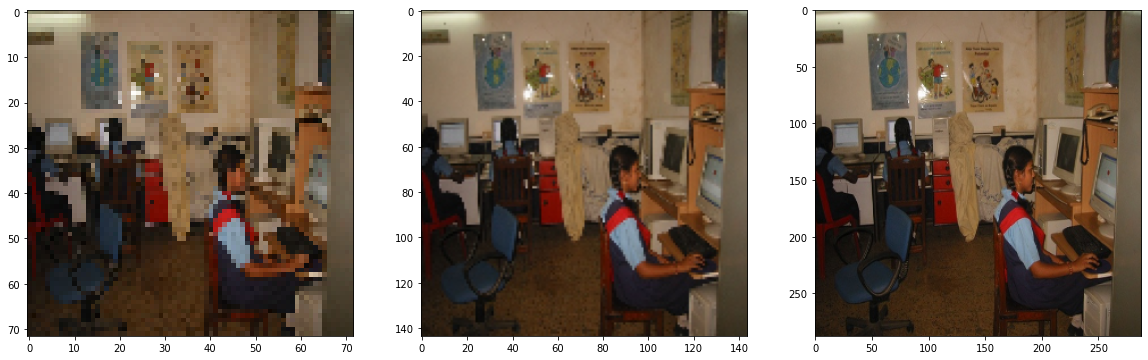

In [17]:
def plot_multiple_images(ind, X, y_mid, y_large):
    fig, ax = plt.subplots(1,3, figsize=(20,6))
    ax[0].imshow(X[ind])
    ax[1].imshow(y_mid[ind])
    ax[2].imshow(y_large[ind])
    
plot_multiple_images(15, X, y_mid, y_large)

## Sidenote: Collecting the results
Along this assignment I will colellect the evaluation metrics: [PSNR, MAE, MSE] to a table which I will present in the summary section.

In [8]:
from prettytable import PrettyTable
results = PrettyTable(['Model', 'Loss Func.', 'loss', 'y_mid_loss', 'y_large_loss', 
                       'y_mid_PSNR', 'y_mid_MSE', 'y_mid_MAE', 'y_large_PSNR', 'y_large_MSE', 
                       'y_large_MAE', 'Runtime','lr','Epoches', 'Batch Size', 'Optimizer'])
results.float_format = "10.4"

# Step 2: Creating an initial model
In this step, I will create an initial fully convolutional network as a starting point. This model serves as a baseline for the next trials.

In [9]:
def get_simple_conv_model(input_shape):
    
    inp = Input(shape=input_shape)
    X = Conv2D(64,3, activation='relu', padding='same')(inp)
    X = Conv2D(64,3, activation='relu', padding='same')(X)
    X = UpSampling2D(size=2, interpolation='nearest')(X)
    out = Conv2D(3,1, activation='sigmoid')(X)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=[PSNR, 'MSE', 'MAE'])
    return model

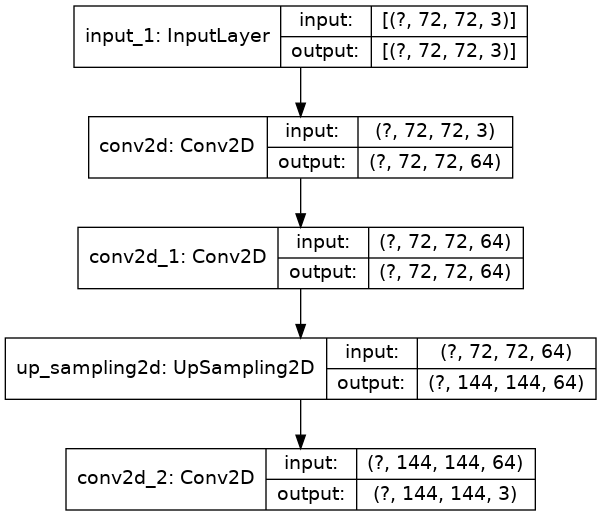

In [10]:
model = get_simple_conv_model(input_shape=(X.shape[1:]))
keras.utils.plot_model(model, show_shapes=True)

In [11]:
time1 = time.time()
model.fit(X_train, 
          y_mid_train, 
          validation_data=(X_val, y_mid_val),
          epochs=100)
time2 = time.time()
runtime = time2 - time1

Epoch 1/100
25/25 [==============================] - 1s 29ms/step - loss: 0.0616 - PSNR: 15.2516 - MSE: 0.0616 - MAE: 0.2089 - val_loss: 0.0315 - val_PSNR: 18.7126 - val_MSE: 0.0315 - val_MAE: 0.1452
Epoch 2/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0168 - PSNR: 22.3975 - MSE: 0.0168 - MAE: 0.0965 - val_loss: 0.0107 - val_PSNR: 25.0515 - val_MSE: 0.0107 - val_MAE: 0.0716
Epoch 3/100
25/25 [==============================] - 0s 20ms/step - loss: 0.0100 - PSNR: 25.8831 - MSE: 0.0100 - MAE: 0.0680 - val_loss: 0.0088 - val_PSNR: 27.1817 - val_MSE: 0.0088 - val_MAE: 0.0623
Epoch 4/100
25/25 [==============================] - 0s 20ms/step - loss: 0.0089 - PSNR: 27.2722 - MSE: 0.0089 - MAE: 0.0620 - val_loss: 0.0084 - val_PSNR: 27.6503 - val_MSE: 0.0084 - val_MAE: 0.0598
Epoch 5/100
25/25 [==============================] - 0s 20ms/step - loss: 0.0085 - PSNR: 27.7149 - MSE: 0.0085 - MAE: 0.0598 - val_loss: 0.0082 - val_PSNR: 28.0805 - val_MSE: 0.0082 - val_MAE: 0.0585


4/4 [==============================] - 0s 6ms/step - loss: 0.0074 - PSNR: 30.7148 - MSE: 0.0074 - MAE: 0.0505


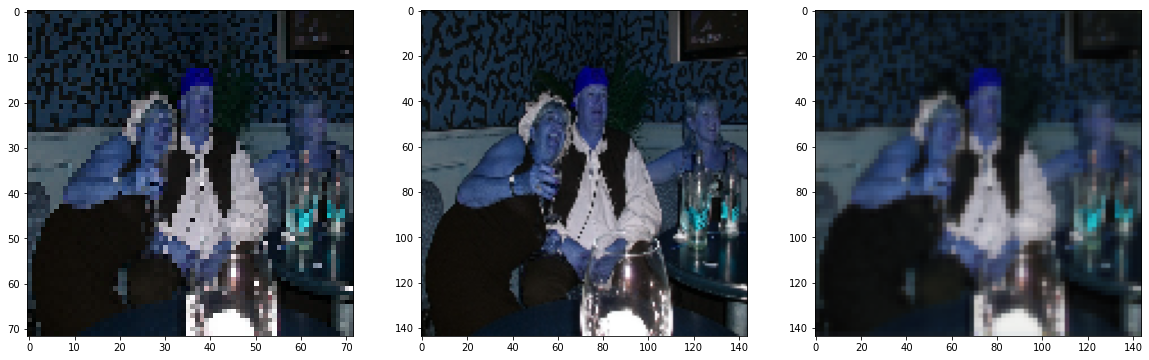

In [12]:
pred = model.predict(X_test)
loss, psnr, mse, mae = model.evaluate(X_test, [y_mid_test, y_large_test])
results.add_row(["Step 2\n(initial)", 'MSE', loss, loss, '-', psnr, mse, mae, '-', '-', '-', runtime, '0.001', '100', '32', 'Adam'])
plot_multiple_images(42, X_test, y_mid_test, pred)

## Results

We can see an improvement in resolution, and we can see that the objects in the image are recognaizable in our predicted image. With that being said, we easily observe that the model mostly smoothes and blurs the images by adding similarly colored pixels around the original pixels. We achieved PSNR of 30.20 on the test set. We will consider this model as I baseline for the next model we will create.

# Step 3: Adding another output block
Now, I will add another block to our model so that I’ll have both 144x144x3 output along with 288x288x3 output as follows:

In [13]:
def get_2out_conv_model(input_shape):
    
    inp = Input(shape=input_shape)
    X = Conv2D(64,3, activation='relu', padding='same')(inp)
    X = Conv2D(64,3, activation='relu', padding='same')(X)
    X = UpSampling2D(size=2, interpolation='nearest')(X)
    out1 = Conv2D(3,1, activation='sigmoid', name='y_mid')(X)
    X = UpSampling2D(size=2, interpolation='nearest')(X)
    out2 = Conv2D(3,1, activation='sigmoid', name='y_large')(X)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse',metrics=[PSNR, 'MSE', 'MAE'])
    return model

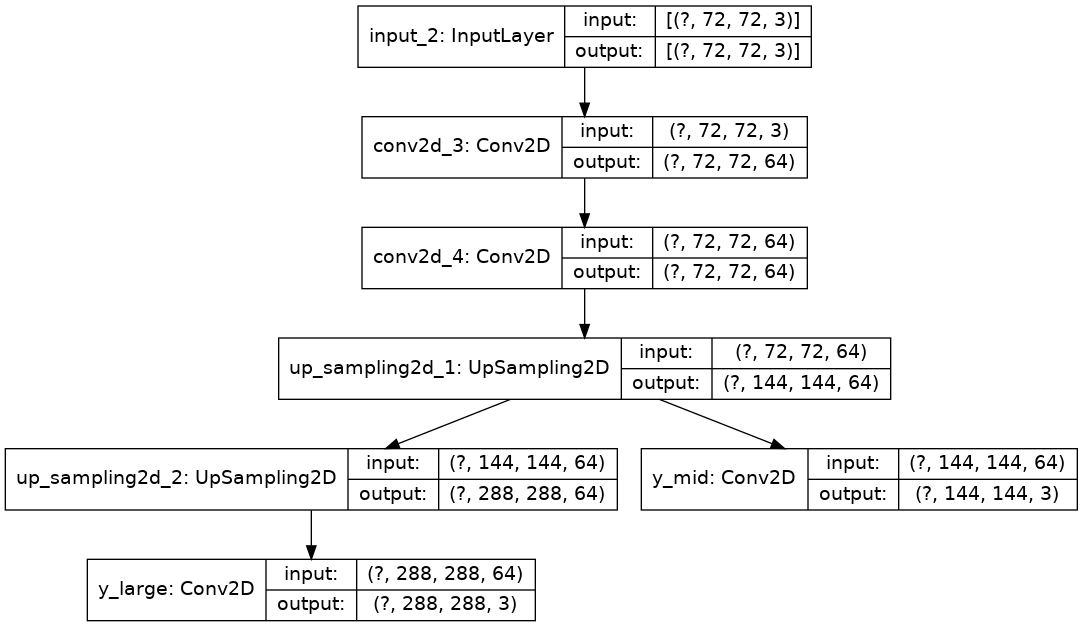

In [14]:
model = get_2out_conv_model(input_shape=(X.shape[1:]))
keras.utils.plot_model(model, show_shapes=True)

In [15]:
time1 = time.time()
model.fit(X_train, 
          [y_mid_train,y_large_train], 
          validation_data=(X_val, [y_mid_val,y_large_val]), 
          epochs=100)
time2 = time.time()
runtime = time2 - time1

Epoch 1/100
25/25 [==============================] - 2s 70ms/step - loss: 0.1261 - y_mid_loss: 0.0618 - y_large_loss: 0.0642 - y_mid_PSNR: 15.1164 - y_mid_MSE: 0.0618 - y_mid_MAE: 0.2105 - y_large_PSNR: 14.8908 - y_large_MSE: 0.0642 - y_large_MAE: 0.2145 - val_loss: 0.0752 - val_y_mid_loss: 0.0353 - val_y_large_loss: 0.0400 - val_y_mid_PSNR: 18.0244 - val_y_mid_MSE: 0.0353 - val_y_mid_MAE: 0.1555 - val_y_large_PSNR: 17.3440 - val_y_large_MSE: 0.0400 - val_y_large_MAE: 0.1654
Epoch 2/100
25/25 [==============================] - 2s 62ms/step - loss: 0.0396 - y_mid_loss: 0.0187 - y_large_loss: 0.0209 - y_mid_PSNR: 21.9934 - y_mid_MSE: 0.0187 - y_mid_MAE: 0.1035 - y_large_PSNR: 20.9495 - y_large_MSE: 0.0209 - y_large_MAE: 0.1098 - val_loss: 0.0214 - val_y_mid_loss: 0.0107 - val_y_large_loss: 0.0106 - val_y_mid_PSNR: 24.9919 - val_y_mid_MSE: 0.0107 - val_y_mid_MAE: 0.0720 - val_y_large_PSNR: 24.7099 - val_y_large_MSE: 0.0106 - val_y_large_MAE: 0.0716
Epoch 3/100
25/25 [=====================

4/4 [==============================] - 0s 18ms/step - loss: 0.0152 - y_mid_loss: 0.0076 - y_large_loss: 0.0076 - y_mid_PSNR: 30.1581 - y_mid_MSE: 0.0076 - y_mid_MAE: 0.0527 - y_large_PSNR: 30.2189 - y_large_MSE: 0.0076 - y_large_MAE: 0.0522


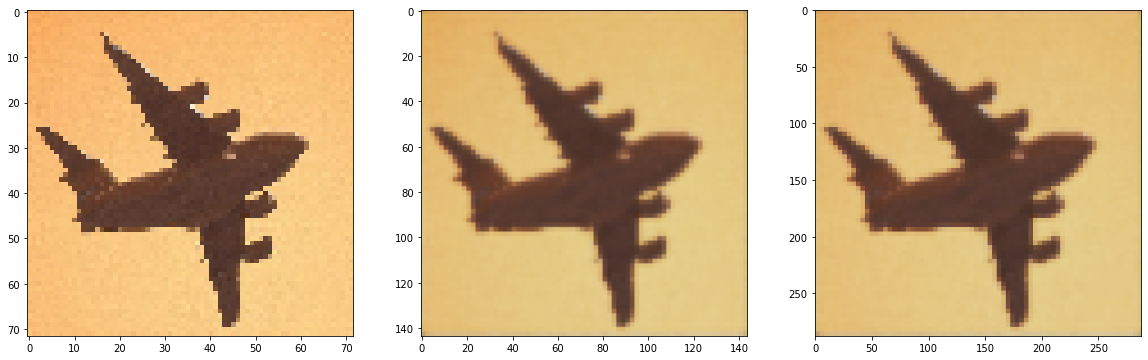

In [16]:
pred = model.predict(X_test)
pred_y_mid = pred[0]
pred_y_large = pred[1]
loss, y_mid_loss, y_large_loss, y_mid_PSNR, \
y_mid_MSE, y_mid_MAE, y_large_PSNR, y_large_MSE, y_large_MAE = model.evaluate(X_test, [y_mid_test, y_large_test])
results.add_row(["Step 3\n(mid+large)", 'MSE', loss, y_mid_loss, y_large_loss, y_mid_PSNR, y_mid_MSE, y_mid_MAE, \
                 y_large_PSNR, y_large_MSE, y_large_MAE, runtime, '0.001', '100', 32, 'Adam'])
plot_multiple_images(10, X_test, pred_y_mid, pred_y_large)

## Results
Adding another output block, our model now predicts large res image as well. Having done a few tweaks to the model, our PSNR slightly improved, achieving PSNR of 30.41 on the mid res and PSNR of 30.45 on the large res. With respect to image quality, this model introduces no improvement whatsoever (to the naked eye) as the predictions on the test set still look just like smoothened version of the original.

# Step 4: Adding residual blocks
Now I will add residual blocks into the process. As we've learned in class, residual block in deep learning utilizes skip connections, or shortcuts to jump over some layers. They are the building blocks in networks like [ResNet](https://arxiv.org/abs/1512.03385). The purpose in this step is to utilize the power of residual blocks to our task of super resolution.

In [17]:
def get_res_conv_model(input_shape):
    
    def ResBlock(cnl):
        inp = Input(shape=(None,None,cnl))
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(X)
        X = Add()([inp, X])
        out = LeakyReLU(alpha=0.2)(X)
        return Model(inp,out)
    
    inp = Input(shape=(None,None,3))
    X = Conv2D(32,1)(inp)
    X = Activation(LeakyReLU(alpha=0.2))(X)
    X = ResBlock(32)(X)
    X = ResBlock(32)(X)
    X = UpSampling2D()(X)
    out1 = Conv2D(3,3, padding='same')(X)
    out1 = Activation('sigmoid', name='y_mid')(out1)
    X = ResBlock(32)(X)
    X = ResBlock(32)(X)
    X = UpSampling2D()(X)
    out2 = Conv2D(3,1, padding='same')(X)
    out2 = Activation('sigmoid', name='y_large')(out2)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse', metrics=[PSNR, 'MSE', 'MAE'])
    return model

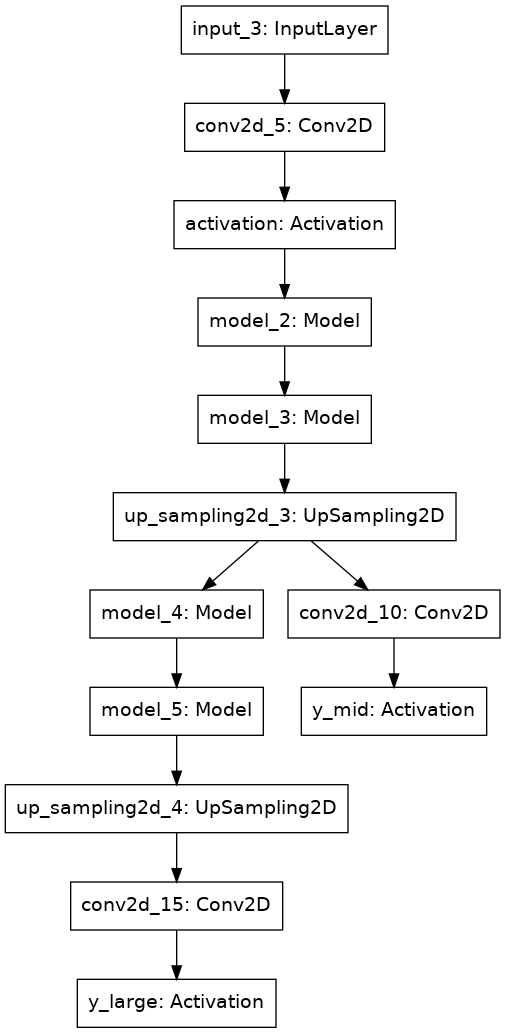

In [18]:
model = get_res_conv_model(input_shape=(X.shape[1:]))
keras.utils.plot_model(model)

In [19]:
time1 = time.time()
model.fit(X_train,
          [y_mid_train,y_large_train],
          validation_data=(X_val, [y_mid_val,y_large_val]),
          epochs=50)
time2 = time.time()
runtime = time2 - time1

Epoch 1/50
25/25 [==============================] - 2s 100ms/step - loss: 0.1173 - y_mid_loss: 0.0676 - y_large_loss: 0.0497 - y_mid_PSNR: 14.3980 - y_mid_MSE: 0.0676 - y_mid_MAE: 0.2208 - y_large_PSNR: 16.4825 - y_large_MSE: 0.0497 - y_large_MAE: 0.1782 - val_loss: 0.0592 - val_y_mid_loss: 0.0414 - val_y_large_loss: 0.0179 - val_y_mid_PSNR: 16.5732 - val_y_mid_MSE: 0.0414 - val_y_mid_MAE: 0.1708 - val_y_large_PSNR: 20.7934 - val_y_large_MSE: 0.0179 - val_y_large_MAE: 0.0995
Epoch 2/50
25/25 [==============================] - 2s 88ms/step - loss: 0.0346 - y_mid_loss: 0.0214 - y_large_loss: 0.0132 - y_mid_PSNR: 20.4289 - y_mid_MSE: 0.0214 - y_mid_MAE: 0.1110 - y_large_PSNR: 23.1103 - y_large_MSE: 0.0132 - y_large_MAE: 0.0835 - val_loss: 0.0223 - val_y_mid_loss: 0.0117 - val_y_large_loss: 0.0106 - val_y_mid_PSNR: 23.9720 - val_y_mid_MSE: 0.0117 - val_y_mid_MAE: 0.0767 - val_y_large_PSNR: 25.0270 - val_y_large_MSE: 0.0106 - val_y_large_MAE: 0.0722
Epoch 3/50
25/25 [=======================

4/4 [==============================] - 0s 23ms/step - loss: 0.0133 - y_mid_loss: 0.0067 - y_large_loss: 0.0065 - y_mid_PSNR: 31.6253 - y_mid_MSE: 0.0067 - y_mid_MAE: 0.0474 - y_large_PSNR: 32.0933 - y_large_MSE: 0.0065 - y_large_MAE: 0.0459


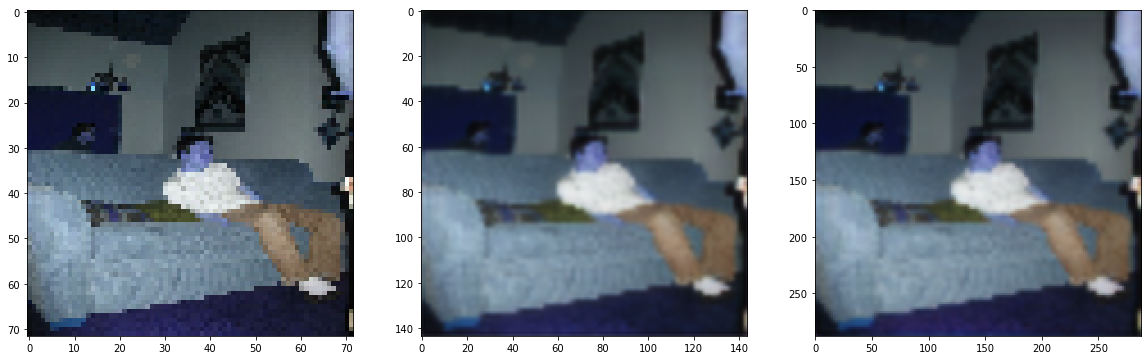

In [20]:
pred = model.predict(X_test)
pred_y_mid = pred[0]
pred_y_large = pred[1]
loss, y_mid_loss, y_large_loss, y_mid_PSNR, \
y_mid_MSE, y_mid_MAE, y_large_PSNR, y_large_MSE, y_large_MAE = model.evaluate(X_test, [y_mid_test, y_large_test])
results.add_row(["Step 4\n(residual blocks)", 'MSE', loss, y_mid_loss, y_large_loss, y_mid_PSNR, y_mid_MSE, y_mid_MAE, \
                 y_large_PSNR, y_large_MSE, y_large_MAE, runtime, '0.001', '100', 32, 'Adam'])
plot_multiple_images(43, X_test, pred_y_mid, pred_y_large)

## Results
Adding residual blocks allowed our model to learn a more complex function. This can be said based on the metrics: we now have PSNR of 31.05 and 31.56 on the mid and large predictions respectively.

# Step 5: Dilated (Atrous) convolutional blocks
Having seen the improvements with residual blocks, we will now turn to replacing the residual blocks we defined above with a dilated (Atrous) convolutional block. Dilated Bottleneck Block is an image model block used in the [DetNet](https://paperswithcode.com/method/dilated-bottleneck-block) convolutional neural network architecture. It employs a bottleneck structure with dilated convolutions to efficiently enlarge the receptive field.

In [21]:
def get_dilated_conv_model(input_shape):
    
    def DilatedBlock(cnl):
        inp = Input(shape=(None,None,cnl))
        d1 = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), dilation_rate=1, padding='same')(inp)
        d2 = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), dilation_rate=2, padding='same')(inp)
        d3 = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), dilation_rate=4, padding='same')(inp)
        c = Concatenate(axis=-1)([d1,d2,d3])
        a = LeakyReLU(alpha=0.2)(c)
        out = Conv2D(cnl,1)(a)
        return Model(inp,out)
    
    inp = Input(shape=(None,None,3))
    X = Conv2D(32,1)(inp)
    X = Activation(LeakyReLU(alpha=0.2))(X)
    X = DilatedBlock(32)(X)
    X = UpSampling2D(interpolation='bilinear')(X)
    out1 = Conv2D(3,1, padding='same')(X)
    out1 = Activation('sigmoid', name='y_mid')(out1)
    X = DilatedBlock(32)(X)
    X = UpSampling2D(interpolation='bilinear')(X)
    out2 = Conv2D(3,1, padding='same')(X)
    out2 = Activation('sigmoid', name='y_large')(out2)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse', metrics=[PSNR, 'MSE', 'MAE'])
    return model

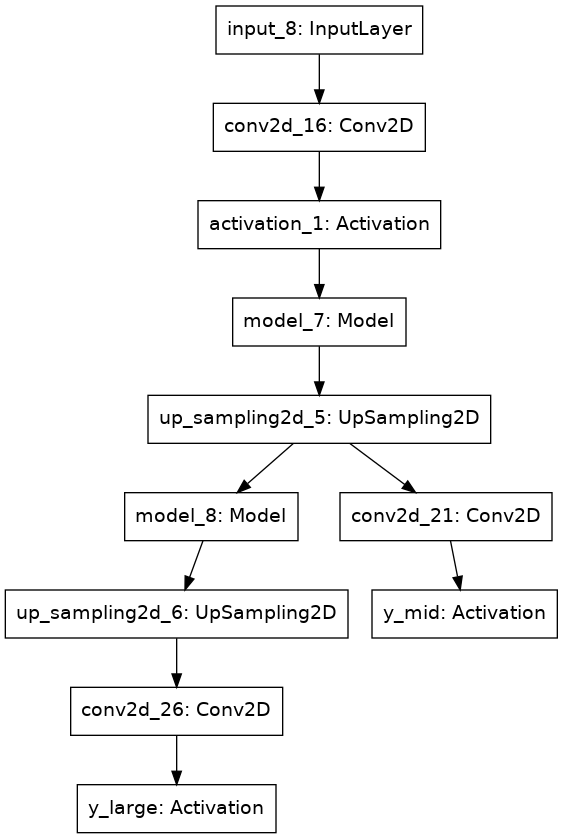

In [22]:
model = get_dilated_conv_model(input_shape=(X.shape[1:]))
keras.utils.plot_model(model)

In [23]:
time1 = time.time()
model.fit(X_train,
          [y_mid_train,y_large_train],
          validation_data=(X_val, [y_mid_val,y_large_val]),
          epochs=30)
time2 = time.time()
runtime = time2 - time1

Epoch 1/30
25/25 [==============================] - 3s 123ms/step - loss: 0.1109 - y_mid_loss: 0.0659 - y_large_loss: 0.0450 - y_mid_PSNR: 14.8215 - y_mid_MSE: 0.0659 - y_mid_MAE: 0.2181 - y_large_PSNR: 16.9834 - y_large_MSE: 0.0450 - y_large_MAE: 0.1695 - val_loss: 0.0619 - val_y_mid_loss: 0.0470 - val_y_large_loss: 0.0149 - val_y_mid_PSNR: 16.4695 - val_y_mid_MSE: 0.0470 - val_y_mid_MAE: 0.1833 - val_y_large_PSNR: 22.0488 - val_y_large_MSE: 0.0149 - val_y_large_MAE: 0.0900
Epoch 2/30
25/25 [==============================] - 2s 100ms/step - loss: 0.0458 - y_mid_loss: 0.0324 - y_large_loss: 0.0133 - y_mid_PSNR: 18.3851 - y_mid_MSE: 0.0324 - y_mid_MAE: 0.1479 - y_large_PSNR: 23.5549 - y_large_MSE: 0.0133 - y_large_MAE: 0.0825 - val_loss: 0.0297 - val_y_mid_loss: 0.0187 - val_y_large_loss: 0.0110 - val_y_mid_PSNR: 21.3691 - val_y_mid_MSE: 0.0187 - val_y_mid_MAE: 0.1057 - val_y_large_PSNR: 24.6490 - val_y_large_MSE: 0.0110 - val_y_large_MAE: 0.0738
Epoch 3/30
25/25 [======================

4/4 [==============================] - 0s 26ms/step - loss: 0.0132 - y_mid_loss: 0.0069 - y_large_loss: 0.0063 - y_mid_PSNR: 30.4765 - y_mid_MSE: 0.0069 - y_mid_MAE: 0.0496 - y_large_PSNR: 31.7982 - y_large_MSE: 0.0063 - y_large_MAE: 0.0453


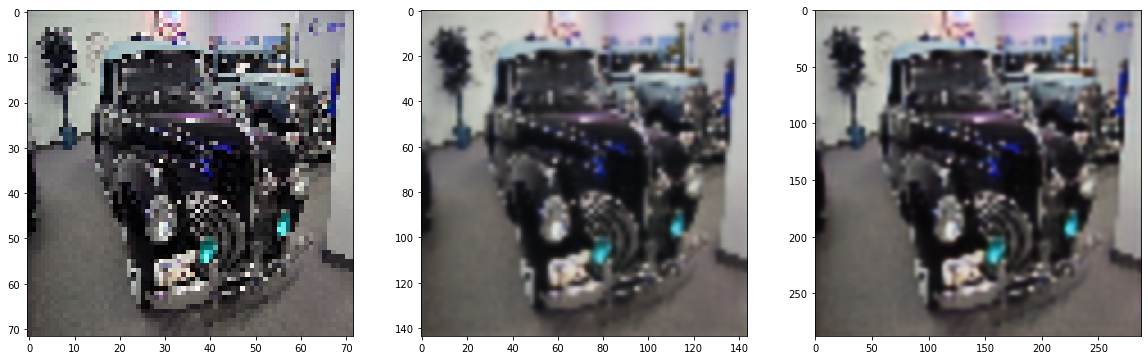

In [24]:
pred = model.predict(X_test)
pred_y_mid = pred[0]
pred_y_large = pred[1]
loss, y_mid_loss, y_large_loss, y_mid_PSNR, \
y_mid_MSE, y_mid_MAE, y_large_PSNR, y_large_MSE, y_large_MAE = model.evaluate(X_test, [y_mid_test, y_large_test])
results.add_row(["Step 5\n(dilated blocks)", 'MSE', loss, y_mid_loss, y_large_loss, y_mid_PSNR, y_mid_MSE, y_mid_MAE, \
                 y_large_PSNR, y_large_MSE, y_large_MAE, runtime, '0.001', '100', 32, 'Adam'])
plot_multiple_images(44, X_test, pred_y_mid, pred_y_large)

## Results
Generally speaking, the use of dilated convolutions does not seem to change the results significantly, as the images look almost identical to the ones from the plain ResNet model. Metrics wise, the results are interesting: we got worse PSNR on the mid-scale (30.91) but better on the large-scale (32.05) in comparison to the previous model.

# Step 6: Feature Extraction with VGG16
Now I will use another important tool of DL that I've learned in class, which is Transfer Learning. I will add a pretrained network feature extractor to the network. I chose VGG16 since it is proven to be useful in the task of Transfer Learning.

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_feat_ext_conv_model(input_shape):
    
    def fe_model():
        vgg = VGG16(weights='imagenet', include_top=False)
        extractor = Model(inputs=vgg.input,
                      outputs=vgg.get_layer('block1_conv2').output)
        extractor.compile(loss='mse', optimizer='adam', metrics=[PSNR])
        
        for l in extractor.layers:
            l.trainable=False
            
        return extractor
    
    def ResBlock(cnl):
        inp = Input(shape=(None,None,cnl))
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(X)
        X = Add()([inp, X])
        out = LeakyReLU(alpha=0.2)(X)
        return Model(inp,out)

    inp = Input(shape=(None,None,3))
    X = Conv2D(32,1)(inp)
    X = Activation(LeakyReLU(alpha=0.2))(X)
    X = ResBlock(32)(X)
    X = ResBlock(32)(X)
    out = fe_model()(inp)
    X = Concatenate(axis=-1)([X,out])
    X = UpSampling2D(interpolation='bilinear')(X)
    out1 = Conv2D(3,1, padding='same')(X)
    out1 = Activation('sigmoid', name='y_mid')(out1)
    X = UpSampling2D(interpolation='bilinear')(X)
    out2 = Conv2D(3,1, padding='same')(X)
    out2 = Activation('sigmoid', name='y_large')(out2)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse', metrics=[PSNR, 'MSE', 'MAE'])
    return model

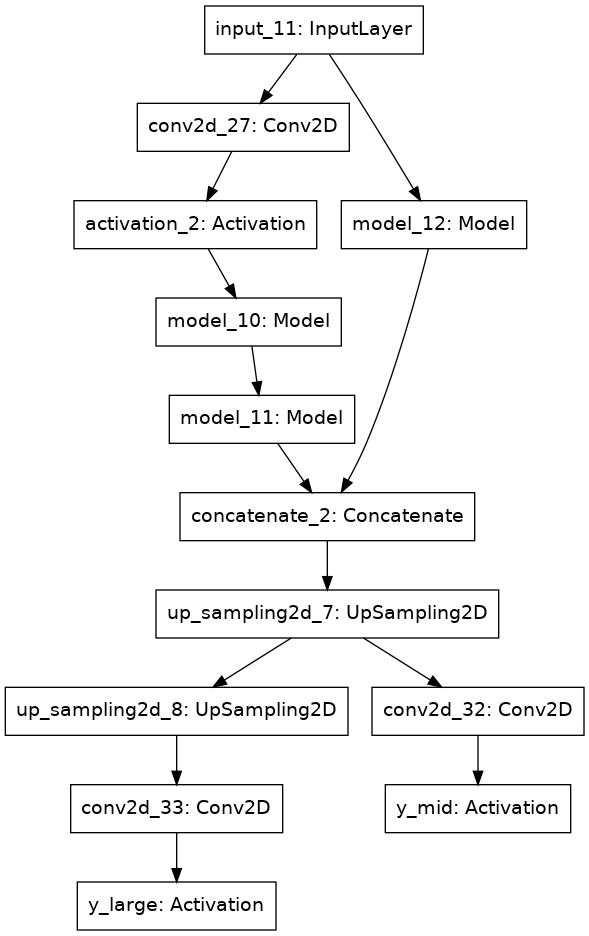

In [26]:
model = get_feat_ext_conv_model(input_shape=(X.shape[1:]))
keras.utils.plot_model(model)

In [27]:
time1 = time.time()
model.fit(X_train,
          [y_mid_train,y_large_train], 
          validation_data=(X_val, [y_mid_val,y_large_val]), 
          epochs=30)
time2 = time.time()
runtime = time2 - time1

Epoch 1/30
25/25 [==============================] - 3s 108ms/step - loss: 0.3425 - y_mid_loss: 0.1923 - y_large_loss: 0.1503 - y_mid_PSNR: 7.9815 - y_mid_MSE: 0.1923 - y_mid_MAE: 0.3544 - y_large_PSNR: 10.0828 - y_large_MSE: 0.1503 - y_large_MAE: 0.3053 - val_loss: 0.1944 - val_y_mid_loss: 0.0998 - val_y_large_loss: 0.0946 - val_y_mid_PSNR: 11.3756 - val_y_mid_MSE: 0.0998 - val_y_mid_MAE: 0.2470 - val_y_large_PSNR: 13.3176 - val_y_large_MSE: 0.0946 - val_y_large_MAE: 0.2315
Epoch 2/30
25/25 [==============================] - 2s 97ms/step - loss: 0.1220 - y_mid_loss: 0.0627 - y_large_loss: 0.0594 - y_mid_PSNR: 14.5993 - y_mid_MSE: 0.0627 - y_mid_MAE: 0.1876 - y_large_PSNR: 16.2658 - y_large_MSE: 0.0594 - y_large_MAE: 0.1764 - val_loss: 0.0804 - val_y_mid_loss: 0.0377 - val_y_large_loss: 0.0427 - val_y_mid_PSNR: 17.4981 - val_y_mid_MSE: 0.0377 - val_y_mid_MAE: 0.1460 - val_y_large_PSNR: 17.7950 - val_y_large_MSE: 0.0427 - val_y_large_MAE: 0.1510
Epoch 3/30
25/25 [========================

4/4 [==============================] - 0s 23ms/step - loss: 0.0146 - y_mid_loss: 0.0075 - y_large_loss: 0.0071 - y_mid_PSNR: 29.0565 - y_mid_MSE: 0.0075 - y_mid_MAE: 0.0526 - y_large_PSNR: 29.5951 - y_large_MSE: 0.0071 - y_large_MAE: 0.0506


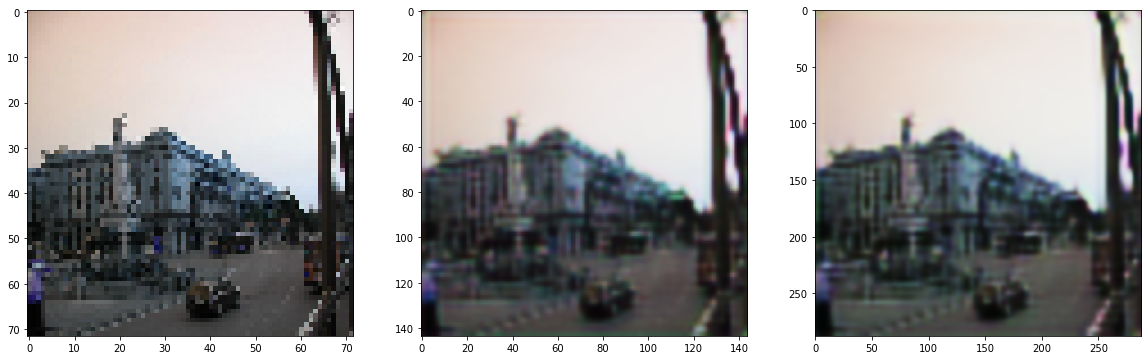

In [28]:
pred = model.predict(X_test)
pred_y_mid = pred[0]
pred_y_large = pred[1]
loss, y_mid_loss, y_large_loss, y_mid_PSNR, \
y_mid_MSE, y_mid_MAE, y_large_PSNR, y_large_MSE, y_large_MAE = model.evaluate(X_test, [y_mid_test, y_large_test])
results.add_row(["Step 6\n(Feature Extraction)", 'MSE', loss, y_mid_loss, y_large_loss, y_mid_PSNR, y_mid_MSE, y_mid_MAE, \
                 y_large_PSNR, y_large_MSE, y_large_MAE, runtime, '0.001', '100', 32, 'Adam'])
plot_multiple_images(45, X_test, pred_y_mid, pred_y_large)

## Results
This trial with VGG16 feature extraction was interesting, but it did not provide better results on the test set. We got worse PSNR values when compared to the previous models. We can even notice somewhat disturted images in the predictions (colors are not correct). The lesson from this trial was that transfer learning is a powerful tool, but not in all cases.

# Step 7: using ```tf.depth_to_space```
In this step, I will replace the ```Upsampling2D``` layer with ```tf.depth_to_space```. ```tf.depth_to_space``` rearranges data from depth into blocks of spatial data. This is the reverse transformation of SpaceToDepth. More specifically, this op outputs a copy of the input tensor where values from the depth dimension are moved in spatial blocks to the height and width dimensions. The attr block_size indicates the input block size and how the data is moved.
<br>
<center><img src="https://pbs.twimg.com/media/Ct0hcPRVIAAdox2.jpg" align="center"/></center>

In [29]:
import tensorflow as tf

In [30]:
def get_depth_2_space_model(input_shape):
    
    def fe_model():
        vgg = VGG16(weights='imagenet', include_top=False)
        extractor = Model(inputs=vgg.input,
                      outputs=vgg.get_layer('block1_conv2').output)
        extractor.compile(loss='mse', optimizer='adam')
        
        for l in extractor.layers:
            l.trainable=False
            
        return extractor
    
    def ResBlock(cnl):
        inp = Input(shape=(None,None,cnl))
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(X)
        X = Add()([inp, X])
        out = LeakyReLU(alpha=0.2)(X)
        return Model(inp,out)

    inp = Input(shape=(None,None,3))
    x = Conv2D(32,1)(inp)
    x = Activation(LeakyReLU(alpha=0.2))(x)
    x = ResBlock(32)(x)
    x = ResBlock(32)(x)
    y = fe_model()(inp)
    x = concatenate([x,y],axis=-1)
    x = tf.nn.depth_to_space(x,2)
    out1 = Conv2D(3,1,padding='same')(x)
    out1 = Activation('sigmoid', name='y_mid')(out1)
    x = Conv2D(32,1)(x)
    x = ResBlock(32)(x)
    x = ResBlock(32)(x)
    x = tf.nn.depth_to_space(x,2)
    out2 = Conv2D(3,1,padding='same')(x)
    out2 = Activation('sigmoid', name='y_large')(out2)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse', metrics=[PSNR, 'MSE', 'MAE'])
    return model

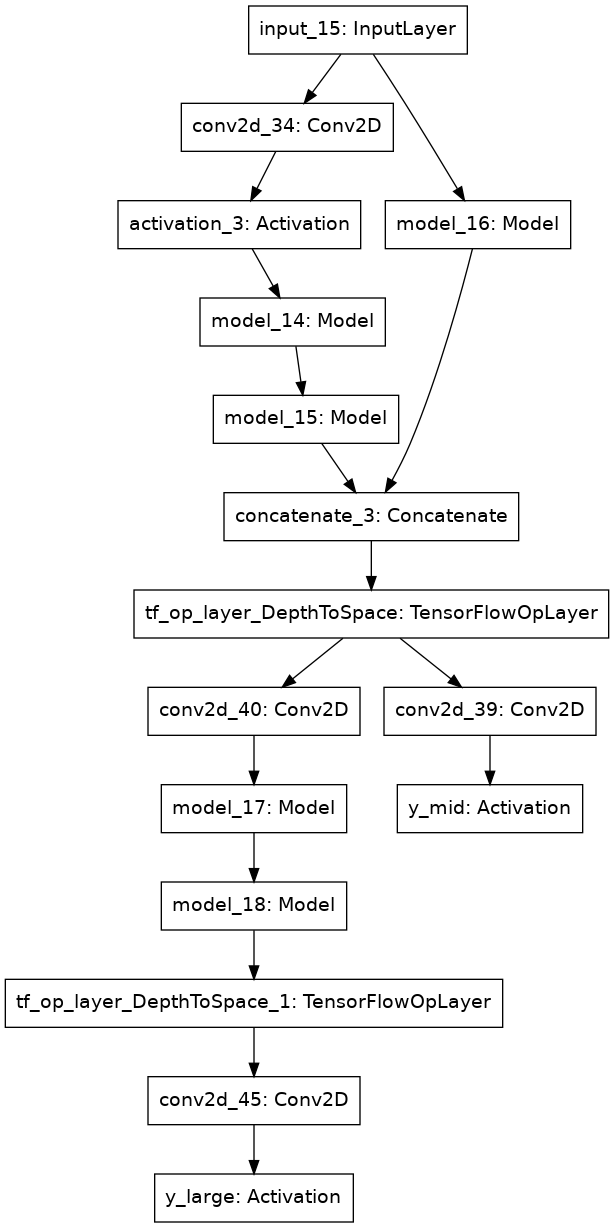

In [31]:
model = get_depth_2_space_model(input_shape=(X.shape[1:]))
keras.utils.plot_model(model)

In [32]:
model.fit(X_train,
          [y_mid_train,y_large_train], 
          validation_data=(X_val, [y_mid_val,y_large_val]), 
          epochs=30)

Epoch 1/30
25/25 [==============================] - 2s 97ms/step - loss: 0.2667 - y_mid_loss: 0.1748 - y_large_loss: 0.0919 - y_mid_PSNR: 10.6305 - y_mid_MSE: 0.1748 - y_mid_MAE: 0.3323 - y_large_PSNR: 13.1369 - y_large_MSE: 0.0919 - y_large_MAE: 0.2378 - val_loss: 0.1945 - val_y_mid_loss: 0.1469 - val_y_large_loss: 0.0476 - val_y_mid_PSNR: 11.8341 - val_y_mid_MSE: 0.1469 - val_y_mid_MAE: 0.2911 - val_y_large_PSNR: 16.0392 - val_y_large_MSE: 0.0476 - val_y_large_MAE: 0.1682
Epoch 2/30
25/25 [==============================] - 2s 83ms/step - loss: 0.1547 - y_mid_loss: 0.1269 - y_large_loss: 0.0278 - y_mid_PSNR: 13.2461 - y_mid_MSE: 0.1269 - y_mid_MAE: 0.2613 - y_large_PSNR: 19.1297 - y_large_MSE: 0.0278 - y_large_MAE: 0.1240 - val_loss: 0.1340 - val_y_mid_loss: 0.1147 - val_y_large_loss: 0.0192 - val_y_mid_PSNR: 13.7170 - val_y_mid_MSE: 0.1147 - val_y_mid_MAE: 0.2460 - val_y_large_PSNR: 20.6471 - val_y_large_MSE: 0.0192 - val_y_large_MAE: 0.1027
Epoch 3/30
25/25 [========================

4/4 [==============================] - 0s 24ms/step - loss: 0.0259 - y_mid_loss: 0.0182 - y_large_loss: 0.0076 - y_mid_PSNR: 23.5712 - y_mid_MSE: 0.0182 - y_mid_MAE: 0.0929 - y_large_PSNR: 28.1604 - y_large_MSE: 0.0076 - y_large_MAE: 0.0553


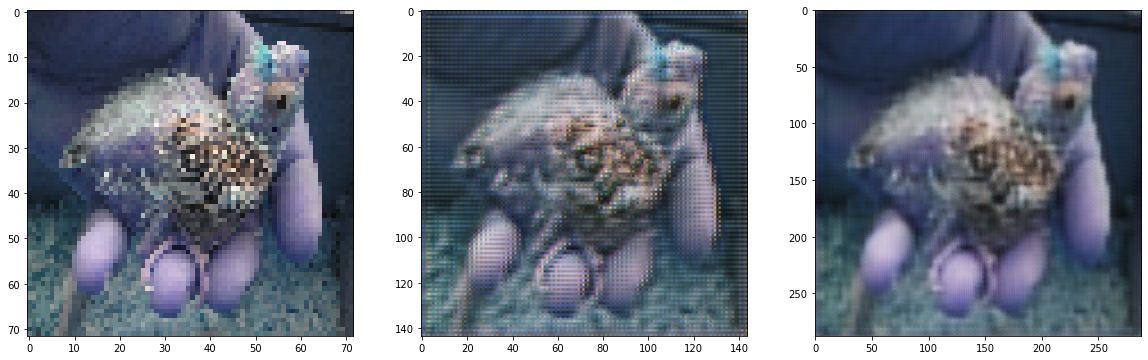

In [33]:
pred = model.predict(X_test)
pred_y_mid = pred[0]
pred_y_large = pred[1]
loss, y_mid_loss, y_large_loss, y_mid_PSNR, \
y_mid_MSE, y_mid_MAE, y_large_PSNR, y_large_MSE, y_large_MAE = model.evaluate(X_test, [y_mid_test, y_large_test])
results.add_row(["Step 7\n(depth_to_space)", 'MSE', loss, y_mid_loss, y_large_loss, y_mid_PSNR, y_mid_MSE, y_mid_MAE, \
                 y_large_PSNR, y_large_MSE, y_large_MAE, runtime, '0.001', '100', 32, 'Adam'])
plot_multiple_images(46, X_test, pred_y_mid, pred_y_large)

## Results
We can see that using the ```depth_to_space``` scaling layer does not improve the resutls. In fact, the mid res predicted images have even more blurs then before. It seems that the have some pattern of little dots with noisy colors on them. While the high res images still look unimpresive, and worse than even the basic multi output model. We can see in the metrics as well that the psnr of the mid res image is much lower compared to other models, which numericly explains the blurs.

# Step 8: Creating a "GIF callback"

In this step we are going to inherit the keras ```Callback``` class to create our custom callback. Out callback will take a snapshot of the output at the end of every epoch. Finally, we will use these snapshots to create a gif of the super resolution process.

In [34]:
def add_epoch_text(img, epoch_num): 
    title_text = f'Epoc: {epoch_num}'
    title_font = ImageFont.truetype('arialbd.ttf', 14)
    my_image = (img * 255).astype(np.uint8)
    img = Image.fromarray(my_image)
    image_editable = ImageDraw.Draw(img)
    image_editable.text((5,5), title_text, font=title_font)
    return img

In [35]:
import imageio
from PIL import Image, ImageFont, ImageDraw 

class TakeSnapshot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        img = X_test[15,:,:,:]
        x = np.expand_dims(img, 0)
        pred = self.model.predict(x)
        pred = pred[1][0,:,:,:]
        pred = add_epoch_text(pred, epoch)
        for i in range(3): images.append(pred)
    def on_train_begin(self, logs=None):
        global images
        images = []
    def on_train_end(self, logs=None):
        imageio.mimsave('./training_over_epochs.gif', images) # Save to .gif

# Summary

## Optimizing a Model

Now after we had a few iterations over our problem, let's revisit the model from step 4 and compare different settings. I chose the model from step 4 because it it basic but still relatively good, and it will enable me to isolate the improvements I am going to suggest:

- [X] Train on the whole dataset
- [X] A few architecture tweaks: more residual blocks

First let's redefine our train, val, test spltis to use all 5011 images of PascalVOC 2007 dataset:

In [36]:
X_train, X_test, y_mid_train, y_mid_test = \
    train_test_split(X, y_mid, test_size=0.2, random_state=SEED)

X_val, X_test, y_mid_val, y_mid_test = \
    train_test_split(X_test, y_mid_test, test_size=0.5, random_state=SEED)

X_train, X_test, y_large_train, y_large_test = \
    train_test_split(X, y_large, test_size=0.2, random_state=SEED)

X_val, X_test, y_large_val, y_large_test = \
    train_test_split(X_test, y_large_test, test_size=0.5, random_state=SEED)

And now I'll define the re-visited model from step 4:

In [40]:
def model_step4_revisited(input_shape):
    
    def ResBlock(cnl):
        inp = Input(shape=(None,None,cnl))
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(inp)
        X = Conv2D(cnl,3, activation=LeakyReLU(alpha=0.2), padding='same')(X)
        X = Add()([inp, X])
        out = LeakyReLU(alpha=0.2)(X)
        return Model(inp,out)
    
    inp = Input(shape=(None,None,3))
    X = Conv2D(32,1)(inp)
    X = Activation(LeakyReLU(alpha=0.2))(X)
    X = ResBlock(32)(X)
    X = ResBlock(32)(X)
    X = UpSampling2D()(X)
    out1 = Conv2D(3,3, padding='same')(X)
    out1 = Activation(LeakyReLU(alpha=0.3), name='y_mid')(out1)
    X = ResBlock(32)(X)
    X = ResBlock(32)(X)
    X = UpSampling2D()(X)
    out2 = Conv2D(3,1, padding='same')(X)
    out2 = Activation('sigmoid', name='y_large')(out2)
    
    model = Model(inputs=inp, outputs=[out1,out2])
    model.compile(optimizer='adam', loss='mse', metrics=[PSNR, 'MSE', 'MAE'])
    return model

In [ ]:
model = model_step4_revisited(X.shape[1:])

model.fit(X_train, 
          [y_mid_train,y_large_train], 
          validation_data=(X_val, [y_mid_val,y_large_val]), 
          epochs=50,
         callbacks=[TakeSnapshot()])

Epoch 1/50
126/126 [==============================] - 15s 122ms/step - loss: 0.0291 - y_mid_loss: 0.0127 - y_large_loss: 0.0163 - y_mid_PSNR: 26.2905 - y_mid_MSE: 0.0127 - y_mid_MAE: 0.0698 - y_large_PSNR: 24.7929 - y_large_MSE: 0.0163 - y_large_MAE: 0.0845 - val_loss: 0.0156 - val_y_mid_loss: 0.0080 - val_y_large_loss: 0.0076 - val_y_mid_PSNR: 29.3842 - val_y_mid_MSE: 0.0080 - val_y_mid_MAE: 0.0538 - val_y_large_PSNR: 29.1618 - val_y_large_MSE: 0.0076 - val_y_large_MAE: 0.0535
Epoch 2/50
126/126 [==============================] - 13s 101ms/step - loss: 0.0146 - y_mid_loss: 0.0074 - y_large_loss: 0.0072 - y_mid_PSNR: 30.1472 - y_mid_MSE: 0.0074 - y_mid_MAE: 0.0509 - y_large_PSNR: 29.4500 - y_large_MSE: 0.0072 - y_large_MAE: 0.0522 - val_loss: 0.0145 - val_y_mid_loss: 0.0073 - val_y_large_loss: 0.0071 - val_y_mid_PSNR: 30.6958 - val_y_mid_MSE: 0.0073 - val_y_mid_MAE: 0.0502 - val_y_large_PSNR: 30.3773 - val_y_large_MSE: 0.0071 - val_y_large_MAE: 0.0505
Epoch 3/50
126/126 [==============

In [ ]:
pred = model.predict(X_test)
pred_y_mid = pred[0]
pred_y_large = pred[1]
loss, y_mid_loss, y_large_loss, y_mid_PSNR, \
y_mid_MSE, y_mid_MAE, y_large_PSNR, y_large_MSE, y_large_MAE = model.evaluate(X_test, [y_mid_test, y_large_test])
results.add_row(["Optimized Model", 'MSE', loss, y_mid_loss, y_large_loss, y_mid_PSNR, y_mid_MSE, y_mid_MAE, \
                 y_large_PSNR, y_large_MSE, y_large_MAE, runtime, '0.001', '100', 32, 'Adam'])
plot_multiple_images(47, X_test, pred_y_mid, pred_y_large)

## Results
We can see that training on the entire data set did not help much. The PSNR metric seems a little higher then the previeus models (thanks to the more data), and we can still see the same phenomena of smoothening the image instead of really "super resolution" it. This is likly due to the simplicity of the model and the veraity of the data. Because the data is very diverse, and the model is very simple, the models is unable to generate additional information ontop of the base image, because it does not understand the image. This means that all it can do is enlarge and try and smooth our the colors to seem less pixelated and closer to the original.

## Model Training GIF
The bellow animated images illustrates the training process of our model, over the epochs. I've used the ```TakeSnapshot()``` callback defined earlier to save a predictions of some image (taken from the test set) to see how the leanring imrpoves over epochs. This GIF strengthens my claim that 20-30 epochs are sufficient in our case.

In [ ]:
from IPython.display import Image
Image(filename="./training_over_epochs.gif")

# Final Report

In this assignment I've practiced on the image super resolution task using deep learnign techqniues. I've learned that this task is not as simple as I thought, and even after iterating over several different models, each one more complex that the other, I still cannot say i'm satisfied with the results I've got, but I've learned a lot from it. From this experience, the things that introduced the biggest improvements were the addition of residual blocks. All across this assignment I evaluated the results with respect to Peak signal-to-noise ratio (PSNR) metric, which is proven to be the most accurate when evaluating image loss and reconstruction.

In [ ]:
print(results)

It can be clearly seen that training on the entire dataset did not help much. The improvements over the iterations are not dramatic, and the models  mostly smoothens the image and remove pixelations, but not necessarily does "super resolution". This is likly due to the simplicity of the models, and even though we've used our best "tricks"  we've learned in the course - it might not be enough. It might be because of the lack of data: even though we've trained over ```5000 / 8 = 4000``` images, perhaps this task requires a bigger, more diverse and more detailed dataset to train on. In addition, I beleive state-of-the-art super res. algorithms do more sophisticated thigns with regards to the relations between adjacent pixel, etc.

To sum up, the my key take-aways from this assignment are the following:
 - [X] Solving a deep learning problem is an iterative process.
 - [X] More data is sometimes not enough...
 - [X] ...but it's always nice to have.
 - [X] Knowing the correct evaluation is important (PSNR vs. MSE, etc.).